# Neural Structured Learning on Time Series
Two novelties are implemented in this notebook:
* Use the GraphNet framework for time-series in order to discover and exploit degradation trends in the same experiment
* Use implicit reparametrization gradients to learn with SGD the parameters of a gamma distribution instead of an empirical error on the output. This is closer to reality and should work better.


## Load data:

In [1]:
from collections import OrderedDict
import os
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras import Sequential,Model
import tensorflow.keras as keras

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)

import numpy as np
import matplotlib.pyplot as pplot
tfd = tfp.distributions
from ipywidgets import FloatSlider, IntSlider, interact, interactive


import pandas as pd

from fictitious_example.dataset_utils import *
from fictitious_example.minigraphnets import *
from datasets.femto_bearing import FEMTOBearingsDataset


ModuleNotFoundError: No module named 'datasets'

## Loading the train/test sets

In [2]:
femto_dataset = FEMTOBearingsDataset()


training set:
01 0 1_7 1502
05 0 1_3 1802
06 0 1_5 2302
07 1 2_3 1202
08 0 1_4 1139
09 1 2_5 2002
13 1 2_1 911
15 0 1_1 2803

testing set:
16 0 1_6 2302
02 2 3_2 1637


In [3]:
inds_exp_target, inds_exp_source = [femto_dataset.inds_exp_target, femto_dataset.inds_exp_source]

In [4]:
assert(len(set(inds_exp_source).intersection(inds_exp_target)) == 0)

In **GraphNets** some code to make graph inputs for this dataset. The graph encodes in practice the *inductive biases* we are baking into the algorithm. In particular, in this application we are representing the following biases:
* The slow progression of damage may be inferred from arbitrary pairs of points
* Averaging estimates from several points yields better estimates than from fewer ones


In [5]:
from utils import get_indices, data_from_experiment, get_graph_data, get_graph_data_multiple_experiments, get_multi_batch

# Definition of GraphNet functions and the GraphNet:

In [41]:

# import os
# import numpy as np
# import tensorflow as tf
# import tensorflow.keras as keras
# from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D
# from tensorflow.keras import Sequential, Model
# import tensorflow_probability as tfp
# tfd = tfp.distributions

# def make_attn_aggregator( nedge_state, n_degree = 1, nheads = 5,activation = None):
#     nedges = None
#     xin1 = tf.keras.layers.Input(shape = (nedges,nedge_state)) # 1st dim is number of incoming edges

#     K1 = Dense(nheads, activation = activation, use_bias = False)(xin1)
#     Q1 = Dense(nheads, activation = activation, use_bias=False)(xin1)
#     attnv = tf.keras.activations.softmax(
#         tf.einsum('...jl, ...km->...jkm',K1,Q1)/(tf.sqrt(float(nedge_state*nheads))), axis = -2) 
    
#     s = tf.einsum('...jkm,...kl -> ...jl',attnv, xin1)/nheads#*tf.sqrt(indegree) # I don't know how to get dynamic shape for better properties of the layer...
#     s = tf.reduce_mean(s,0)
#     #s= tf.keras.layers.LayerNormalization()(s)
    
#     return Model(inputs = xin1, outputs=  s)


class GraphNetFunctionFactory:
    def __init__(self, NETWORK_SIZE_GLOBAL = 50, USE_PRENETWORKS = True, EDGE_NODE_STATE_SIZE = 15):
        """
        Summary: 
          A factory for graphnet functions. It is custom made for the problems of RUL from time-series. 
          It can be adapted to other prediction models. All models (except the aggregation function) are 
          relatively small MLPs terminated by sigmoid()*tanh() activation (simple tanh could also work).
          
        NETWORK_SIZE_GLOBAL: A parameter controlling the width of different networks involved.
    
        USE_PRENETWORKS:     Use a deeper architecture (see code)
        
        GRAPH_STATE_SIZE:    the size of the node states, and edge states. This is needed
                             to create consistent graph functions. Eventhough here I'm using the same global size,
                             the sizes of edge states and node states can be different.
        """
        self.network_size_global = NETWORK_SIZE_GLOBAL
        self.use_prenetworks = USE_PRENETWORKS
        self.edge_and_node_state_size = EDGE_NODE_STATE_SIZE
    

    def make_gamma_node_observation_mlp(self, n_node_state_output):
        """
        Takes as input a node state and returns a gamma probability distribution
        """
        seq = keras.Sequential()
        NParams= 1;
        NSamples = 100;
        #seq.add(Dense(n_gamma_internal, use_bias = True, activation = "relu", name = "output1"))
        seq.add(Dense(NParams*2, use_bias = False, activation = lambda x : tf.nn.softplus(x),name = "output"));
        def instantiate_gamma(t):
            return tfd.Gamma(concentration = t[...,0:NParams], rate = t[...,NParams:2*NParams])

        #seq.add()
        seq.add(            
            tfp.layers.DistributionLambda(
                make_distribution_fn = lambda t: instantiate_gamma(t),
                convert_to_tensor_fn= lambda s : s.sample(NSamples)))
        seq._set_inputs(tf.keras.layers.Input((n_node_state_output,)))
        return seq

    def weights(self):
        return [*self.core.weights(), *self.graph_indep.weights()];

    def make_edge_function(self,n_edge_state_input = None,n_edge_state_output = None, n_node_state_input = None):
        edge_state_in = Input(shape = (n_edge_state_input), name = "edge_state");
        node_state_sender_in = Input(shape = (n_node_state_input), name = "node_sender");
        node_state_receiver_in = Input(shape = (n_node_state_input), name = "node_receiver");

        ## Building the edge MLP:
        edge_out = keras.layers.concatenate([edge_state_in, node_state_sender_in, node_state_receiver_in])

        if self.use_prenetworks:
            edge_out = Dense(self.network_size_global,  use_bias = False,name = "edge_input")(edge_out)
            edge_out = Dropout(rate = 0.2)(edge_out)

        edge_out_gate = Dense(n_edge_state_output, activation = "sigmoid", use_bias = False,name = "edge_fcnA")(edge_out)
        edge_outB = Dense(n_edge_state_output, activation = "tanh", use_bias = False,name = "edge_fcnB")(edge_out)
        edge_out =  edge_outB * edge_out_gate #+ (1 - edge_out_gate) * edge_state_in


        edge_mlp = Model(
            inputs = [edge_state_in, node_state_sender_in, node_state_receiver_in ] ,
            outputs = edge_out)

        return edge_mlp
    
    def save(self, path):
        gi_path = os.path.join(path,"graph_independent")
        core_path = os.path.join(path,"core")
        if not os.path.exists(path):
            os.makedirs(gi_path)
            os.makedirs(core_path)
            
        self.core.save(core_path)
        self.graph_indep.save(gi_path)
    
    def load(self,path):
        gi_path = os.path.join(path,"graph_independent")
        core_path = os.path.join(path,"core")


    def make_edge_function_gi(self,n_edge_state_input = None, n_edge_state_output = None, n_node_state_input = None):
        # for graph independent.
        if n_edge_state_output is None:
            n_edge_state_output = n_edge_state_input

        edge_state_in = Input(shape = (n_edge_state_input), name = "edge_state");
        edge_out = edge_state_in

        if self.use_prenetworks:
            edge_out = Dense(self.network_size_global,  use_bias = True, name = "edge_gi_input_fcn1")(edge_out)
            edge_out = tf.keras.layers.LeakyReLU()(edge_out)
            edge_out = Dropout(rate = 0.2)(edge_out)
            edge_out = Dense(self.network_size_global,  use_bias = True, name = "edge_gi_input_fcn2")(edge_out)
            edge_out = tf.keras.layers.LeakyReLU()(edge_out)

        edge_out_gate = Dense(n_edge_state_output, use_bias = False, activation = "sigmoid", name = "edge_gi_fcnA")(edge_out)
        edge_outB = Dense(n_edge_state_output, use_bias = False, activation = "tanh", name = "edge_gi_fcnB")(edge_out)
        edge_out = edge_outB * edge_out_gate 
        edge_mlp = Model(inputs = edge_state_in,outputs = edge_out)
        
        return edge_mlp

    def make_edge_aggregation_function(self,edge_out_shape):
        xin = tf.keras.layers.Input(shape = (None,edge_out_shape))
        xout = tf.reduce_mean(xin,0)
        return Model(inputs = xin, outputs= xout)


    def make_node_function(self,n_edge_state_input = None,n_node_state_input = None):
        agg_edge_state_in = Input(shape = (n_edge_state_input), name = "edge_state_agg");
        node_prev_state = Input(shape = (n_node_state_input), name = "node_sender");

        ## Building the edge MLP:
        node_out = keras.layers.concatenate([agg_edge_state_in, node_prev_state]);

        if self.use_prenetworks:
            node_out = Dense(self.network_size_global,  use_bias = True,name = "node_fcn1")(node_out)
            node_out = Dropout(rate = 0.2)(node_out)
            node_out = tf.keras.layers.LeakyReLU()(node_out)
            node_out = Dense(self.network_size_global,  use_bias = True , name = "node_fcn2")(node_out)
            node_out = tf.keras.layers.LeakyReLU()(node_out)
        #node_out = Dense(n_node_state_input, use_bias = False)(node_out)

        node_out_nl = Dense(n_node_state_input, activation = "tanh", use_bias = False,name = "node_fcn_nl")(node_out)
        node_out_gate = Dense(n_node_state_input, activation = "sigmoid", use_bias = False,name = "node_fcn_gate")(node_out)
        node_out = node_out_nl * node_out_gate# + node_prev_state * (1-node_out_gate)

        node_out_model = Model(inputs = [agg_edge_state_in, node_prev_state] ,outputs = node_out)

        return node_out_model



    def make_conv_input_head_node_function(self,edge_input_dummy_size , nfilts = 18, nfilts2 = 50, ksize = 3, output_size = None):

        xin_node_ts = tf.keras.Input(shape = (None, 2) , name = "timeseries_input"); 
        xin_edge_dummy = tf.keras.Input(shape = ( edge_input_dummy_size), name = "edge_input_dummy");

        yout = Conv1D(kernel_size = 1 ,  filters = nfilts2, strides = 1, use_bias= False,name = "conv_fcnA")(xin_node_ts)
        yout = Conv1D(kernel_size=ksize, filters = nfilts, strides=2  , use_bias= False,name = "conv_fcnB")(yout)
        yout = Conv1D(kernel_size=ksize, filters = nfilts, strides=2  , use_bias= False,name = "conv_fcnC")(yout)
        #yout = Dropout(rate = 0.2)(yout)
        yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,use_bias= True)(yout)
        yout = tf.keras.layers.LeakyReLU()(yout)
        yout = keras.layers.AveragePooling1D(pool_size=2)(yout)

        yout = Conv1D(kernel_size = 1 ,  filters = nfilts2, strides = 1, use_bias= False,name = "conv_fcnA3")(yout)
        yout = Conv1D(kernel_size=ksize, filters = nfilts , strides=2  , use_bias= False,name = "conv_fcnB3")(yout)
        yout = Conv1D(kernel_size=ksize, filters = nfilts , strides=2  , use_bias= False,name = "conv_fcnC3")(yout)
        #yout = Dropout(rate = 0.2)(yout)
        yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,use_bias= True)(yout)
        yout = tf.keras.layers.LeakyReLU()(yout)
        #yout = keras.layers.AveragePooling1D(pool_size=2)(yout)

        yout = Conv1D(kernel_size = 1 ,  filters = nfilts2, strides = 1, use_bias= False,name = "conv_fcnA4")(yout)
        yout = Conv1D(kernel_size=ksize, filters = nfilts , strides=2  , use_bias= False,name = "conv_fcnB4")(yout)
        yout = Conv1D(kernel_size=ksize, filters = nfilts , strides=2  , use_bias= False,name = "conv_fcnC4")(yout)
        #yout = Dropout(rate = 0.2)(yout)
        yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,use_bias= True)(yout)
        yout = tf.keras.layers.LeakyReLU()(yout)
        #yout = keras.layers.AveragePooling1D(pool_size=2)(yout)

        #yout = keras.layers.GlobalAveragePooling1D()(yout)
        yout = keras.layers.GlobalMaxPooling1D()(yout)
        yout = Dense(output_size, use_bias = True)(yout)
        yout = keras.layers.LayerNormalization()(yout)
        yout = tf.keras.layers.LeakyReLU()(yout)

        mconv = keras.Model(inputs = [xin_edge_dummy,xin_node_ts], outputs = yout)
        return mconv
    
    def make_graphnet_comp_blocks(self, n_node_state_input_gi = None):
        """
        Prepares the graphnet blocks for the subsequent computation. 
        Subsequently these blocks are composed so that a series of inputs can return
        a gamma distribution directly.
        """
        #NETWORK_STATES_SIZE = 30
        n_node_state_input , n_edge_state_input = [self.edge_and_node_state_size,self.edge_and_node_state_size]
        n_edge_output = n_edge_state_input
        
        batch_size = 10; # An arbitrary number, to create a batch and call the 
                         #functions once to initialize them.

        n_edge_state_input_gi = 1
        n_edge_output_gi = self.edge_and_node_state_size;
        
        ##########################################
        # Graph independent processing:
        edge_mlp_gi = self.make_edge_function_gi(n_edge_state_input = n_edge_state_input_gi,
                                            n_edge_state_output= n_edge_output_gi,
                                            n_node_state_input = n_node_state_input_gi)

        node_mlp_gi = self.make_conv_input_head_node_function(edge_input_dummy_size=n_edge_state_input_gi, output_size = n_node_state_input)

        node_mlp_gi([np.random.randn(batch_size,n_edge_state_input_gi),np.random.randn(batch_size,n_node_state_input_gi,2)])
        
        graph_indep = GraphNet(edge_function = edge_mlp_gi,
                               node_function = node_mlp_gi,
                               edge_aggregation_function= None, 
                               node_to_prob_function= None)

        #########################################
        # Graph processing:
        
        edge_mlp = self.make_edge_function(n_edge_state_input,n_edge_output, n_node_state_input) # THe node state is used for two nodes.
        dat_list= [vv.astype("float32") for vv in [np.random.randn(batch_size,n_edge_state_input), np.random.randn(batch_size,n_node_state_input), np.random.randn(batch_size,n_node_state_input)]]
        edge_mlp(dat_list)

        node_mlp = self.make_node_function(n_edge_state_input, n_node_state_input)
        node_to_prob_mlp = self.make_gamma_node_observation_mlp(n_node_state_input);
        node_to_prob_mlp(np.random.randn(batch_size,n_node_state_input))
        node_mlp([vv.astype("float32") for vv in [np.random.randn(batch_size,n_edge_state_input), np.random.randn(batch_size,n_node_state_input)]])
        per_node_edge_aggregator = self.make_edge_aggregation_function(n_edge_output)
        edge_aggregation_function = per_node_edge_aggregator

        gn = GraphNet(edge_function = edge_mlp,
                      node_function=node_mlp,
                      edge_aggregation_function=edge_aggregation_function,
                      node_to_prob_function= node_to_prob_mlp)
        self.core = gn
        self.graph_indep = graph_indep
        
    def eval_graphnets(self,graph_data_, iterations = 5):
        """
        graph_data_  : is a "graph" object that contains a batch of graphs (more correctly, a graph tuple as DM calls it)
        iterations   : number of core iterations for the computation.
        """
        graph_out = self.graph_indep.graph_eval(graph_data_)
        for iterations in range(iterations):
            graph_out = self.core.graph_eval(graph_out) + graph_out # Addition adds all representations (look at implementation of "Graph")

        # Finally the node_to_prob returns a reparametrized "Gamma" distribution from only the final node state
        return self.core.node_to_prob_function(graph_out.nodes[-1].node_attr_tensor) 


class GraphNet:
    """
    Input is a graph and output is a graph.
    Encapsulates a GraphNet computation iteration.
    
    Supports model loading and saving (for a single GraphNet)
    """
    def __init__(self, edge_function, node_function, edge_aggregation_function, node_to_prob_function):
        self.edge_function             = edge_function
        self.node_function             = node_function
        self.edge_aggregation_function = edge_aggregation_function        
        self.node_to_prob_function = node_to_prob_function
        # Needed to treat the case of no edges.
        # If there are no edges, the aggregated edge state is zero.
        
        self.edge_input_size = self.edge_function.inputs[0].shape[1] # first input of edge mlp is the edge state size by convention.
        
    def weights(self):
        all_weights = [ *self.edge_function.weights, *self.node_function.weights]
        if self.node_to_prob_function is not None:
            all_weights.extend(self.node_to_prob_function.weights)
        
        if self.edge_aggregation_function is not None and not isinstance(self.edge_aggregation_function, type(tf.reduce_mean)):
            all_weights.extend(self.edge_aggregation_function.weights)
            
        return all_weights
    
    def observe_nodes(self, graph):
        probs = [];
        for n in graph.nodes:
            probs.append(self.node_to_prob_function(n.node_attr_tensor))
            
        return probs
        
    def observe_node(self, node):
        self.node_to_prob_function(node)
        
    def graph_eval(self, graph):
        # Evaluate all edge functions:
        self.eval_edge_functions(graph)
        
        batch_size             = graph.nodes[0].shape[0]; # This will be related to the input graph tuple. 
        
        edge_input_size = self.edge_input_size ; # This relates to the graphnet being evaluated.
        
        # Aggregate edges per node:
        edge_to_node_agg_dummy = np.zeros([batch_size, edge_input_size]);
        
        for n in graph.nodes:
            if len(n.incoming_edges) is not 0:                
                if self.edge_aggregation_function is not None:
                    edge_vals_ = tf.stack([e.edge_tensor for e in n.incoming_edges])
                    edge_to_node_agg = self.edge_aggregation_function(edge_vals_)
                    node_attr_tensor = self.node_function([edge_to_node_agg, n.node_attr_tensor])
                    n.set_tensor(node_attr_tensor)
                else:
                    node_attr_tensor = self.node_function([edge_to_node_agg_dummy,n.node_attr_tensor])
                    n.set_tensor(node_attr_tensor)
                    
            else:
                node_attr_tensor = self.node_function([edge_to_node_agg_dummy, n.node_attr_tensor])
                n.set_tensor(node_attr_tensor)
        
        return graph
    
    def save(self, path):
        functions = [self.node_function, self.edge_aggregation_function, self.edge_function, self.node_to_prob_function]
        path_labels = ["node_function", "edge_aggregation_function", "edge_function", "node_to_prob"]
        import os
        if not os.path.exists(path):
            os.makedirs(path)
            
        for model_fcn, label in zip(functions, path_labels):
            if model_fcn is not None:
                d_ = os.path.join(path,label)
                model_fcn.save(d_)
                
    def load(self, path):
        functions = [self.node_function, self.edge_aggregation_function, self.edge_function, self.node_to_prob_function]
        all_paths = ["node_function", "edge_aggregation_function", "edge_function", "node_to_prob"]
        path_label_to_function = {z:v for z,v in zip(all_paths,functions)}
        path_labels = os.listdir(path) #
        
        if not os.path.exists(path):
            print("path does not exist.")
            assert(0)
            
        for l in path_labels:
            d_ = os.path.join(path,l)
            if path is None:
                next
            else:
                model_fcn = tf.keras.models.load_model(d_)
                path_label_to_function[l] = model_fcn
            
           
    def eval_edge_functions(self,graph):
        """
        Evaluate all edge functions
        """
        if self.edge_aggregation_function is None:
            for edge in graph.edges:
                edge_tensor = self.edge_function([edge.edge_tensor])
                edge.set_tensor(edge_tensor)
                
        else:
            for edge in graph.edges:
                edge_tensor = self.edge_function([edge.edge_tensor, edge.node_from.node_attr_tensor, edge.node_to.node_attr_tensor])
                edge.set_tensor(edge_tensor)
                
gtot = GraphNetFunctionFactory(NETWORK_SIZE_GLOBAL = 50, USE_PRENETWORKS = True, EDGE_NODE_STATE_SIZE=15)




In [42]:
gtot.make_graphnet_comp_blocks(femto_dataset.X[0].shape[0])
#gtot.save("/tmp/testtt")



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



# Model Creation:


In [43]:
gn_tot = GraphNetFunctionFactory(NETWORK_SIZE_GLOBAL = 50, 
                                 USE_PRENETWORKS = True,
                                 EDGE_NODE_STATE_SIZE = 30)

gn_tot.make_graphnet_comp_blocks(femto_dataset.X[0].shape[0])



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



# Training

In [44]:
def get_multi_batch_femto(*args, **kwargs):
    new_args = (args[0], femto_dataset)
    return get_multi_batch(*new_args, **kwargs)

In [45]:
curr_data = get_multi_batch_femto(3, source_ds=True,nnodes=5,
                            min_spacing = 1,
                            nseq_range = 100,
                            fixed_spacing_indices=False);
#eval_graphnets(curr_data[0][0].copy())

In [32]:
class LossLogger:
    def __init__(self):
        self.losses  = ["loss", "val_loss"]
        self.loss_history = {k:[] for k in self.losses}
    def append_loss(self, loss_):
        self.loss_history['loss'].append(loss_)
        
    def append_val_loss(self, val_loss_):
        self.loss_history['val_loss'].append(val_loss_)
    
    def print(self):
        loss, val_loss = [self.loss_history[vv] for vv in self.losses]
        print("loss: %2.3f, val_loss %2.3f"%(loss[-1], val_loss[-1]))

class EarlyStopping:
    def __init__(self, patience, loss_handle):
        self.patience = patience
        self.loss_handle = loss_handle
    
    def on_epoch_end(self, epoch):
        break_ = False
        
        if len(self.loss_handle) > 1:
            if np.all(np.min(self.loss_handle[-self.patience:]) > self.min_val):
                print("*** Early stopping. ***")
                break_ = True
                
            else:
                self.min_val = np.min(self.loss_handle)
        else:
            
            self.min_val = self.loss_handle[-1]
        
        return break_
    
class LRScheduler:
    def __init__(self, opt_object, epoch_decay = 50, decay_rate = 0.95):
        self.opt_object = opt_object
        self.epoch_decay = epoch_decay
        self.decay_rate = decay_rate
        
    def on_epoch_end(self,epoch):
        if epoch >= self.epoch_decay:
            lr = self.opt_object.lr.numpy()
            new_lr = lr * self.decay_rate
            print("setting lr to %2.3f"%new_lr)
            self.opt_object.lr.assign(new_lr)
        
        

In [33]:
learning_rate = 0.001;
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss_log = LossLogger()
early_stop = EarlyStopping(20,loss_log.loss_history['val_loss'])
lr_scheduler = LRScheduler(opt, epoch_decay = 40, decay_rate = 0.99)

In [34]:

#@tf.function
# def eval_graphnets(graph_data_, iterations = 2):
#     graph_out = graph_indep.graph_eval(graph_data_)
#     for iterations in range(iterations):
#         graph_out = gn.graph_eval(graph_out) + graph_out
        
#     return node_to_prob_mlp(graph_out.nodes[-1].node_attr_tensor)

#@tf.function
def eval_graphnets_loss(graph_curr_, ycurr_, iterations):#,iterations):
    graph_out = graph_indep.graph_eval(graph_curr_)
    
    for iterations in range(iterations):
        graph_out = gn.graph_eval(graph_out) + graph_out

    prob_out = node_to_prob_mlp(graph_out.nodes[-1].node_attr_tensor)
    loss_vals = -prob_out.log_prob(ycurr_)
    return loss_vals


def graphnet_latent_states(graph_data_, iterations = 2):
    graph_out_tmp = graph_indep.graph_eval(graph_data_)
    lat_states = [graph_out_tmp.copy()]
    for iterations in range(iterations):
        graph_out_tmp = gn.graph_eval(graph_out_tmp) + graph_out
        lat_states.append(graph_out_tmp.copy())
    return lat_states

In [35]:
#lr_scheduler.opt_object.lr.assign(lr_scheduler.opt_object.lr.numpy()*0.9)
#lr_scheduler.opt_object.lr.assign(0.005)

nnodes: 1, seq_range 200 epoch: 0
loss: 11.994, val_loss 13.790


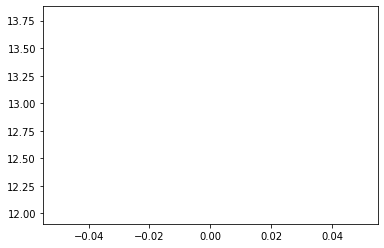

nnodes: 2, seq_range 150 epoch: 1
loss: 11.277, val_loss 12.552
nnodes: 5, seq_range 50 epoch: 2
loss: 11.002, val_loss 12.066
nnodes: 1, seq_range 200 epoch: 3
loss: 11.136, val_loss 12.550
nnodes: 2, seq_range 150 epoch: 4
loss: 10.479, val_loss 11.716
nnodes: 5, seq_range 50 epoch: 5
loss: 10.656, val_loss 11.695
nnodes: 1, seq_range 200 epoch: 6
loss: 10.820, val_loss 12.308
nnodes: 2, seq_range 150 epoch: 7
loss: 10.154, val_loss 11.183
nnodes: 5, seq_range 50 epoch: 8
loss: 10.583, val_loss 11.518
nnodes: 1, seq_range 200 epoch: 9
loss: 10.560, val_loss 11.858
nnodes: 2, seq_range 150 epoch: 10
loss: 9.941, val_loss 11.120


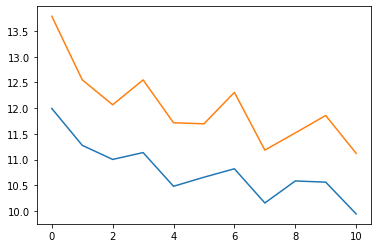

nnodes: 5, seq_range 50 epoch: 11
loss: 10.463, val_loss 11.465
nnodes: 1, seq_range 200 epoch: 12
loss: 10.356, val_loss 11.799
nnodes: 2, seq_range 150 epoch: 13
loss: 9.983, val_loss 10.917
nnodes: 5, seq_range 50 epoch: 14
loss: 10.283, val_loss 11.412
nnodes: 1, seq_range 200 epoch: 15
loss: 10.191, val_loss 11.479
nnodes: 2, seq_range 150 epoch: 16
loss: 9.694, val_loss 10.839
nnodes: 5, seq_range 50 epoch: 17
loss: 10.161, val_loss 11.473
nnodes: 1, seq_range 200 epoch: 18
loss: 9.694, val_loss 10.923
nnodes: 2, seq_range 150 epoch: 19
loss: 9.663, val_loss 10.644
nnodes: 5, seq_range 50 epoch: 20
loss: 9.724, val_loss 10.885


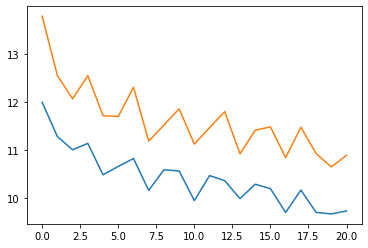

nnodes: 1, seq_range 200 epoch: 21
loss: 9.639, val_loss 10.790
nnodes: 2, seq_range 150 epoch: 22
loss: 9.197, val_loss 10.078
nnodes: 5, seq_range 50 epoch: 23
loss: 10.176, val_loss 11.526
nnodes: 1, seq_range 200 epoch: 24
loss: 9.351, val_loss 10.714
nnodes: 2, seq_range 150 epoch: 25
loss: 9.325, val_loss 10.350
nnodes: 5, seq_range 50 epoch: 26
loss: 9.462, val_loss 10.560
nnodes: 1, seq_range 200 epoch: 27
loss: 9.661, val_loss 10.759
nnodes: 2, seq_range 150 epoch: 28
loss: 8.808, val_loss 9.778
nnodes: 5, seq_range 50 epoch: 29
loss: 9.830, val_loss 11.095
nnodes: 1, seq_range 200 epoch: 30
loss: 9.044, val_loss 10.325


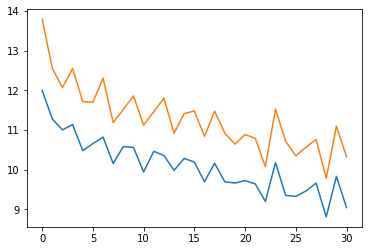

nnodes: 2, seq_range 150 epoch: 31
loss: 9.128, val_loss 10.050
nnodes: 5, seq_range 50 epoch: 32
loss: 9.263, val_loss 10.076
nnodes: 1, seq_range 200 epoch: 33
loss: 8.959, val_loss 10.248
nnodes: 2, seq_range 150 epoch: 34
loss: 8.709, val_loss 9.578
nnodes: 5, seq_range 50 epoch: 35
loss: 9.445, val_loss 10.345
nnodes: 1, seq_range 200 epoch: 36
loss: 8.682, val_loss 9.935
nnodes: 2, seq_range 150 epoch: 37
loss: 8.748, val_loss 9.646
nnodes: 5, seq_range 50 epoch: 38
loss: 9.316, val_loss 10.119
nnodes: 1, seq_range 200 epoch: 39
loss: 8.706, val_loss 9.873
nnodes: 2, seq_range 150 epoch: 40
loss: 8.551, val_loss 9.282
setting lr to 0.001


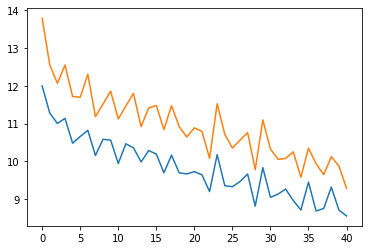

nnodes: 5, seq_range 50 epoch: 41
loss: 9.392, val_loss 10.528
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 42
loss: 8.684, val_loss 9.999
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 43
loss: 8.790, val_loss 9.833
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 44
loss: 8.686, val_loss 9.384
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 45
loss: 8.461, val_loss 9.773
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 46
loss: 8.850, val_loss 9.860
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 47
loss: 8.642, val_loss 9.260
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 48
loss: 8.481, val_loss 9.833
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 49
loss: 8.223, val_loss 9.202
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 50
loss: 8.444, val_loss 9.300
setting lr to 0.001


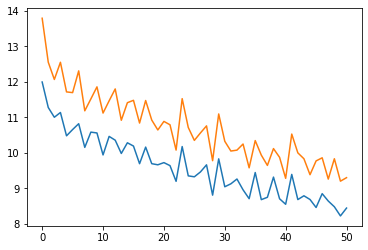

nnodes: 1, seq_range 200 epoch: 51
loss: 8.259, val_loss 9.641
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 52
loss: 7.940, val_loss 8.808
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 53
loss: 8.961, val_loss 10.147
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 54
loss: 8.526, val_loss 10.132
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 55
loss: 8.575, val_loss 9.831
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 56
loss: 8.802, val_loss 9.598
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 57
loss: 8.243, val_loss 9.837
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 58
loss: 8.155, val_loss 9.202
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 59
loss: 8.013, val_loss 8.996
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 60
loss: 7.917, val_loss 9.620
setting lr to 0.001


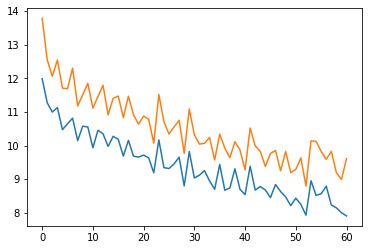

nnodes: 2, seq_range 150 epoch: 61
loss: 7.659, val_loss 8.978
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 62
loss: 7.888, val_loss 9.049
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 63
loss: 7.972, val_loss 9.811
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 64
loss: 8.085, val_loss 9.416
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 65
loss: 7.972, val_loss 9.211
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 66
loss: 7.568, val_loss 9.570
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 67
loss: 7.221, val_loss 8.506
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 68
loss: 7.307, val_loss 8.629
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 69
loss: 7.591, val_loss 9.551
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 70
loss: 7.494, val_loss 8.952
setting lr to 0.001


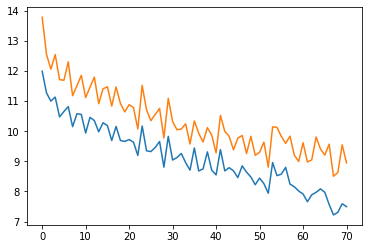

nnodes: 5, seq_range 50 epoch: 71
loss: 7.928, val_loss 9.247
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 72
loss: 7.655, val_loss 9.323
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 73
loss: 7.344, val_loss 9.092
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 74
loss: 8.273, val_loss 9.380
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 75
loss: 9.308, val_loss 11.181
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 76
loss: 8.620, val_loss 10.252
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 77
loss: 7.830, val_loss 9.044
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 78
loss: 8.358, val_loss 9.854
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 79
loss: 7.749, val_loss 8.977
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 80
loss: 7.914, val_loss 9.433
setting lr to 0.001


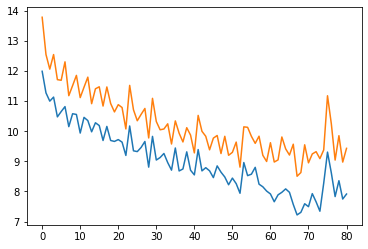

nnodes: 1, seq_range 200 epoch: 81
loss: 7.543, val_loss 9.380
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 82
loss: 7.776, val_loss 9.090
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 83
loss: 7.016, val_loss 8.545
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 84
loss: 7.216, val_loss 9.191
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 85
loss: 7.002, val_loss 8.615
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 86
loss: 6.599, val_loss 8.241
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 87
loss: 6.883, val_loss 8.856
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 88
loss: 6.124, val_loss 7.819
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 89
loss: 6.065, val_loss 8.018
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 90
loss: 6.421, val_loss 8.539
setting lr to 0.001


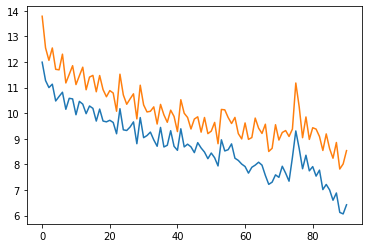

nnodes: 2, seq_range 150 epoch: 91
loss: 5.665, val_loss 7.407
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 92
loss: 5.708, val_loss 7.847
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 93
loss: 6.286, val_loss 8.498
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 94
loss: 5.366, val_loss 7.292
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 95
loss: 5.586, val_loss 7.674
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 96
loss: 6.418, val_loss 8.288
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 97
loss: 5.407, val_loss 7.486
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 98
loss: 5.415, val_loss 7.726
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 99
loss: 8.167, val_loss 10.718
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 100
loss: 7.677, val_loss 9.813
setting lr to 0.001


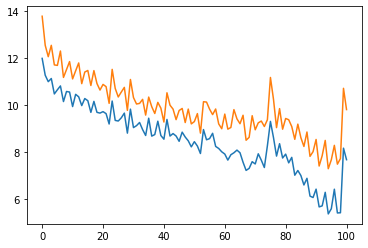

nnodes: 5, seq_range 50 epoch: 101
loss: 7.186, val_loss 8.457
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 102
loss: 6.549, val_loss 8.686
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 103
loss: 5.861, val_loss 8.085
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 104
loss: 5.652, val_loss 7.770
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 105
loss: 5.983, val_loss 8.334
setting lr to 0.001
nnodes: 2, seq_range 150 epoch: 106
loss: 5.424, val_loss 7.602
setting lr to 0.001
nnodes: 5, seq_range 50 epoch: 107
loss: 5.634, val_loss 7.549
setting lr to 0.001
nnodes: 1, seq_range 200 epoch: 108
loss: 5.985, val_loss 8.475
setting lr to 0.000
nnodes: 2, seq_range 150 epoch: 109
loss: 5.698, val_loss 8.100
setting lr to 0.000
nnodes: 5, seq_range 50 epoch: 110
loss: 4.728, val_loss 6.433
setting lr to 0.000


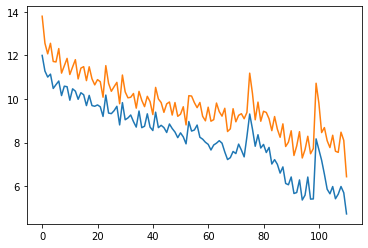

nnodes: 1, seq_range 200 epoch: 111
loss: 5.787, val_loss 8.315
setting lr to 0.000
nnodes: 2, seq_range 150 epoch: 112
loss: 5.003, val_loss 6.824
setting lr to 0.000
nnodes: 5, seq_range 50 epoch: 113
loss: 4.441, val_loss 6.163
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 114
loss: 5.590, val_loss 8.485
setting lr to 0.000
nnodes: 2, seq_range 150 epoch: 115
loss: 4.908, val_loss 6.761
setting lr to 0.000
nnodes: 5, seq_range 50 epoch: 116
loss: 4.502, val_loss 6.397
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 117
loss: 5.677, val_loss 8.698
setting lr to 0.000
nnodes: 2, seq_range 150 epoch: 118
loss: 4.981, val_loss 6.942
setting lr to 0.000
nnodes: 5, seq_range 50 epoch: 119
loss: 4.568, val_loss 6.544
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 120
loss: 5.200, val_loss 7.889
setting lr to 0.000


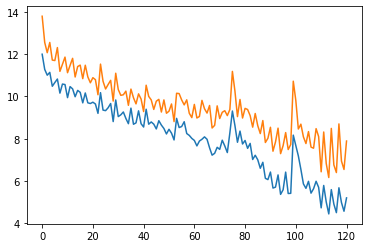

nnodes: 2, seq_range 150 epoch: 121
loss: 4.609, val_loss 6.568
setting lr to 0.000
nnodes: 5, seq_range 50 epoch: 122
loss: 4.927, val_loss 6.547
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 123
loss: 5.660, val_loss 8.689
setting lr to 0.000
nnodes: 2, seq_range 150 epoch: 124
loss: 4.668, val_loss 6.649
setting lr to 0.000
nnodes: 5, seq_range 50 epoch: 125
loss: 4.893, val_loss 6.815
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 126
loss: 5.752, val_loss 8.810
setting lr to 0.000
nnodes: 2, seq_range 150 epoch: 127
loss: 5.685, val_loss 8.073
setting lr to 0.000
nnodes: 5, seq_range 50 epoch: 128
loss: 5.350, val_loss 7.690
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 129
loss: 5.378, val_loss 7.886
setting lr to 0.000
nnodes: 2, seq_range 150 epoch: 130
loss: 4.940, val_loss 7.146
setting lr to 0.000


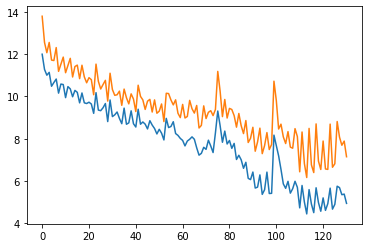

nnodes: 5, seq_range 50 epoch: 131
loss: 4.326, val_loss 6.529
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 132
loss: 5.394, val_loss 8.141
setting lr to 0.000
nnodes: 2, seq_range 150 epoch: 133
loss: 4.428, val_loss 6.654
setting lr to 0.000
*** Early stopping. ***


In [36]:
n_epochs = 300
nbatch  = 300

val_pct = 0.1
fixed_spacing_indices = False;
nnodes_schedule =     [1,2,5] #[10,10,1,2,5]#2,2,3,3]#,1,2,2,1,1,3,3]
nseq_range_schedule = [200,150,50];
min_spacing_schedule =[10];
iterations_schedule = [5]
#nnodes_schedule = [1,2,4,4,5,10,5]
#nseq_range_schedule = [2,5,15,15,20,50,30]
#min_spacing_schedule = [1,1,1,1,1,1]
#iterations_schedule =  [3,2,3,3,4]

#nnodes_schedule = [1,2,5]
#nseq_range_schedule = [20]
#min_spacing_schedule = [1,1,1]
#iterations_schedule = [3,3,3]

for i in range(n_epochs):
    np.random.seed(42); 
    epoch = i
    
    # This makes sure that I always get different training and validation sets (there can still be some overlap but training should work ok)
    nnodes      = nnodes_schedule[i%len(nnodes_schedule)]
    nseq_range  = nseq_range_schedule[i%len(nseq_range_schedule)]
    min_spacing = min_spacing_schedule[i%len(min_spacing_schedule)]
    iterations = iterations_schedule[i%len(iterations_schedule)]
    
    if (nnodes * min_spacing) > nseq_range:
        min_spacing = 10
        nseq_range = nnodes * min_spacing+10
        
    print("nnodes: %i, seq_range %i epoch: %i"%(nnodes, nseq_range, i))
    curr_data = get_multi_batch_femto(nbatch, source_ds=True,nnodes=nnodes,
                                min_spacing = min_spacing,
                                nseq_range = nseq_range,
                                fixed_spacing_indices=fixed_spacing_indices);
    
    loss_epoch = 0;
    val_loss_epoch = 0;
    
    for single_minibatch in curr_data:
        with tf.GradientTape() as tape:
            graph_curr, y_curr = single_minibatch;
            #print(graph_curr)
            #def eval_graphnets_loss(graph_curr_, ycurr_,iterations):
            prob_out = gn_tot.eval_graphnets(graph_curr.copy(), iterations)
            loss_vals = -prob_out.log_prob(y_curr[np.newaxis].T)
            #ycurr_t = y_curr[np.newaxis].T
            #ycurr_t = tf.Variable(ycurr_t)
            #loss_vals=  eval_graphnets_loss(graph_curr.copy(), ycurr_t, tf.constant(iterations))
            
            all_weights =gn_tot.weights() 
            
            
            train_loss = loss_vals[0:int(nbatch*(1-val_pct))];
            
            grads = tape.gradient(train_loss, all_weights)
            all_weights_filt = [all_weights[k] for k in range(len(grads)) if grads[k] is not None]
            grads_filt = [grads[k] for k in range(len(grads)) if grads[k] is not None]
            opt.apply_gradients(zip(grads_filt, all_weights_filt))
            loss_epoch += train_loss/len(y_curr)
        
        val_loss_epoch += tf.reduce_mean(loss_vals[int(-nbatch*(val_pct)):])
        
    loss_log.append_loss(np.sum(loss_epoch.numpy()))
    loss_log.append_val_loss(np.sum(val_loss_epoch.numpy()))
    loss_log.print()
    lr_scheduler.on_epoch_end(epoch)
    if early_stop.on_epoch_end(epoch):
        break
        
    if epoch%10 == 0:
        pplot.plot(loss_log.loss_history['loss'])
        pplot.plot(loss_log.loss_history['val_loss'])
        pplot.show()
        

In [7]:
def graphnet_latent_states(graph_data_, iterations = 2):
    graph_out_tmp = gn_tot.graph_indep.graph_eval(graph_data_)
    lat_states = [graph_out_tmp]
    for iterations in range(iterations):
        graph_out_tmp = gn_tot.core.graph_eval(graph_out_tmp) + graph_out_tmp
        lat_states.append(graph_out_tmp)
    return lat_states

curr_data = get_multi_batch(2, source_ds=True,nnodes=5,
                            min_spacing = 20,
                            nseq_range = 100,
                            fixed_spacing_indices=True);
c = curr_data[0][0]


for c in curr_data:
    c = c[0]
    c = graphnet_latent_states(c.copy(), iterations =5)
    pplot.figure(figsize = (10,5)) 
    pplot.subplot(1,2,1)
    pplot.pcolor(np.vstack([c_.nodes[-1].node_attr_tensor.numpy() for c_ in c]).T)
    pplot.subplot(1,2,2)
    pplot.pcolor(np.vstack([c_.nodes[0].node_attr_tensor.numpy() for c_ in c]).T)
    pplot.show()
    

NameError: name 'get_multi_batch' is not defined

In [8]:
pplot.plot(loss_log.loss_history['loss'])
pplot.plot(loss_log.loss_history['val_loss'])


NameError: name 'pplot' is not defined

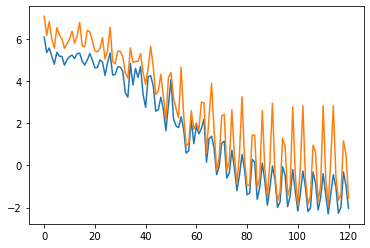

In [264]:
pplot.plot(loss_log.loss_history['loss'])
pplot.plot(loss_log.loss_history['val_loss'])


5


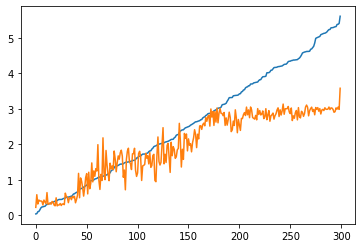

In [41]:
#loss_vals = -prob_out.log_prob(y_curr[np.newaxis].T)
#loss_vals
print(nnodes)
prob_out = gn_tot.eval_graphnets(graph_curr.copy(), iterations)

ids_sort = np.argsort(y_curr);
pplot.plot(y_curr[ids_sort])
pplot.plot(prob_out.mean().numpy().flatten()[ids_sort])

In [42]:
inds_exp_target

[16, 2]

In [43]:
# Inspect the learned embeddings for different experiments. See if some of them cluster.
def get_exp_dat(exp_num, keep_from_end):
    ids = np.argmax(femto_dataset.eid_oh,1) == exp_num
    
    return femto_dataset.X[ids][-keep_from_end:,:,:],femto_dataset.yrem_norm[ids][-keep_from_end:]
#embs = graph_indep.node_function(get_exp_dat(1))
#graph_indep.node_function.summary()

keep_from_end = 100;
all_embs = []
exp_inds_plot = []
yfrom_ends = []
for ee in [*inds_exp_source, *inds_exp_target]:
    g, gg = get_exp_dat(ee, keep_from_end)
    
    e = gn_tot.graph_indep.node_function([np.zeros([g.shape[0],1]).astype("float32") ,g])
    all_embs.append(e)
    exp_inds_plot.append([ee]*keep_from_end)
    yfrom_ends.append(gg)
    
    
exp_inds_plot = np.hstack(exp_inds_plot)
yfrom_ends = np.hstack(yfrom_ends)
#graph_indep.node_function.inputs

#graph_indep.node_function()


In [44]:
istarget = np.zeros_like(exp_inds_plot)
istarget[[e_ for e_,e in enumerate(exp_inds_plot) if e in inds_exp_target]] = 1


In [45]:
all_embs_ = np.vstack([a.numpy() for a in all_embs])
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=4);
tsne = TSNE(n_components=2);
tsne= tsne.fit_transform(all_embs_)
#pplot.scatter(epca[:,0],epca[:,1])


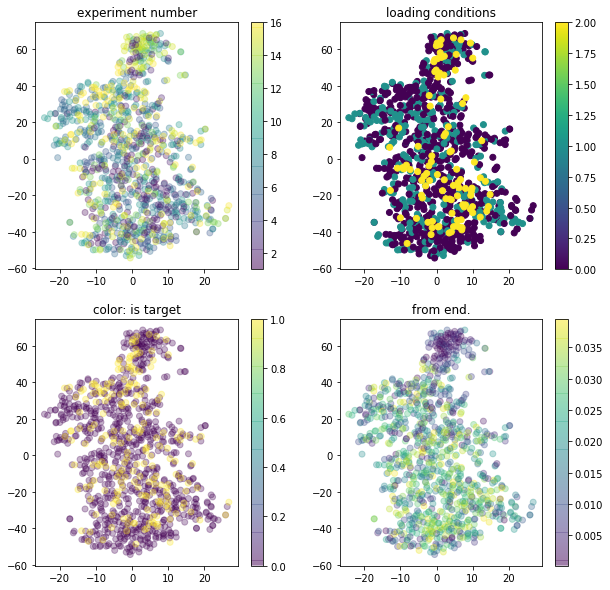

In [46]:
pplot.figure(figsize = (10,10))
pplot.subplot(2,2,1)
pplot.scatter(tsne[:,0], tsne[:,1],c = exp_inds_plot, alpha = 0.3)
pplot.title("experiment number")
pplot.colorbar()
pplot.subplot(2,2,2)
pplot.scatter(tsne[:,0], tsne[:,1],c = [femto_dataset.exp_to_cond_dict[k] for k in exp_inds_plot])
pplot.title("loading conditions")
pplot.colorbar()
pplot.subplot(2,2,3)
pplot.scatter(tsne[:,0], tsne[:,1], c = istarget, alpha = 0.3)
pplot.title("color: is target")
pplot.colorbar()
pplot.subplot(2,2,4)
pplot.scatter(tsne[:,0], tsne[:,1], c = yfrom_ends, alpha = 0.3)
pplot.title("from end.")
pplot.colorbar()
pplot.show()


In [47]:
[exp_to_cond_dict[ii] for ii in inds_exp_source], inds_exp_source

NameError: name 'exp_to_cond_dict' is not defined

In [50]:
#inds_exp_source, inds_exp_target 
targets =[t for t in inds_exp_target if t not in inds_exp_target]
#[(t, exp_to_cond_dict[t]) for t in targets],[(t, exp_to_cond_dict[t]) for t in inds_exp_source]


In [51]:
inds_exp_source

[1, 5, 6, 7, 8, 9, 13, 15]

target


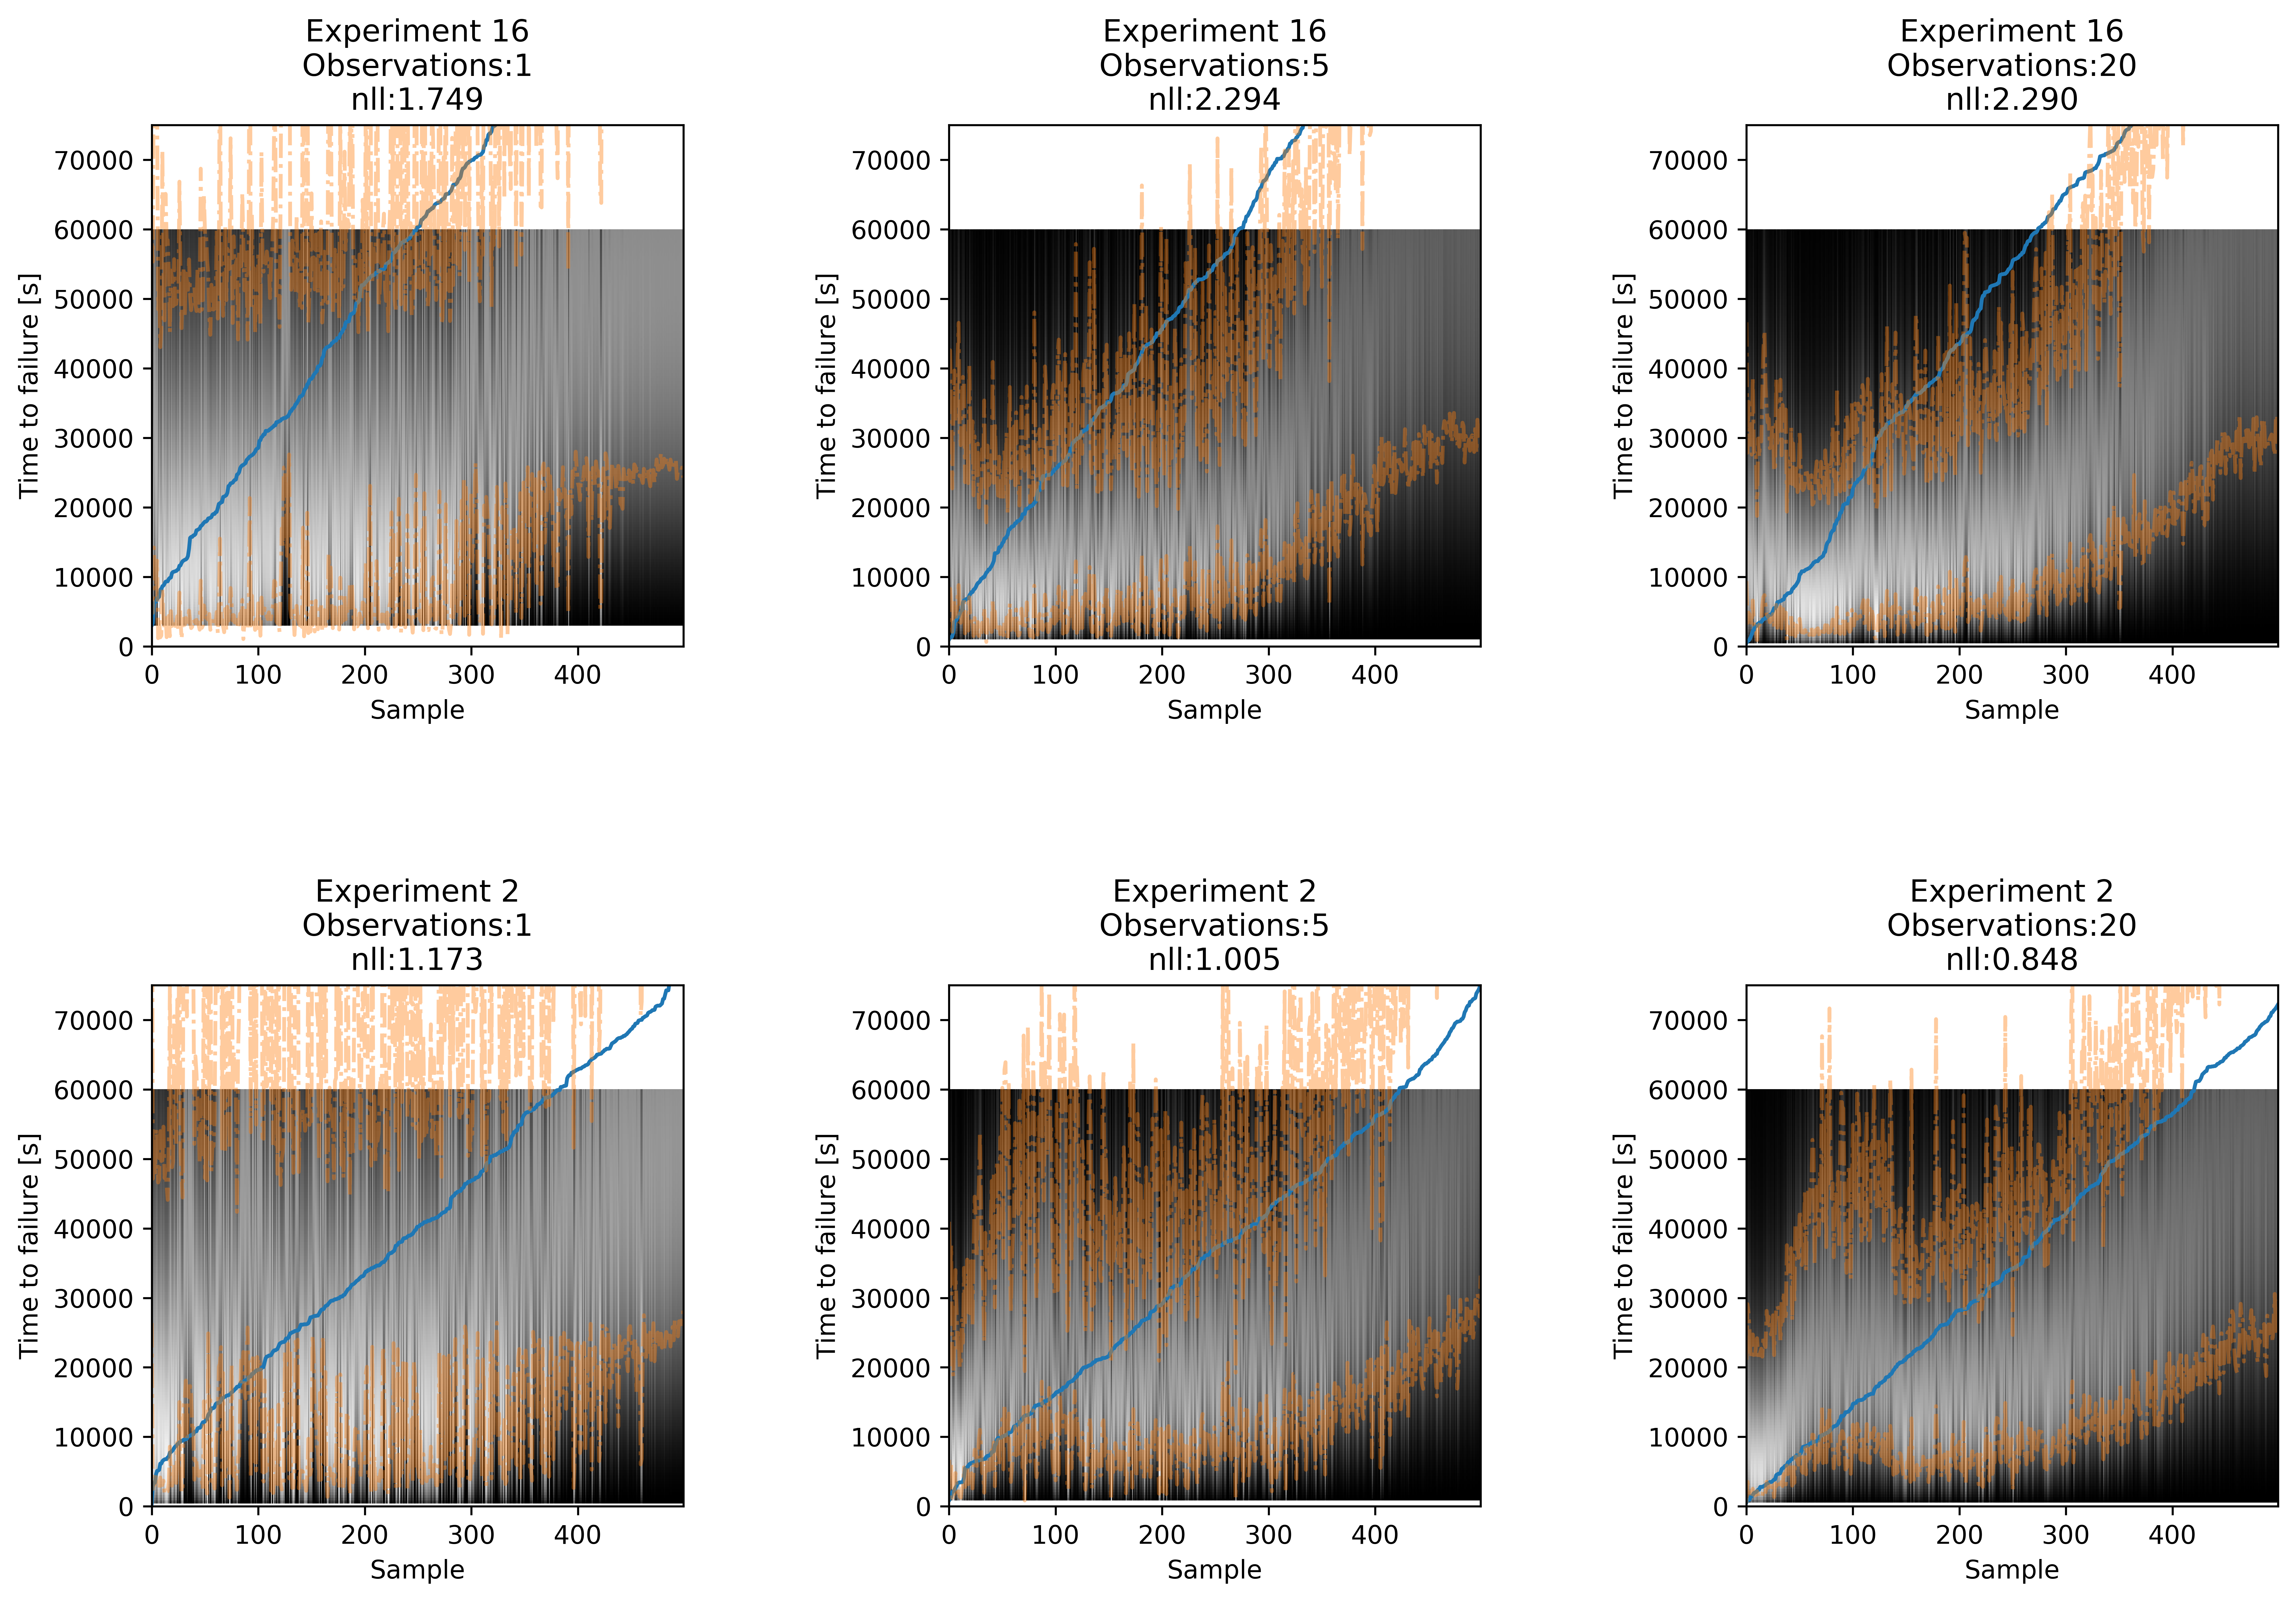

source:


<Figure size 432x288 with 0 Axes>

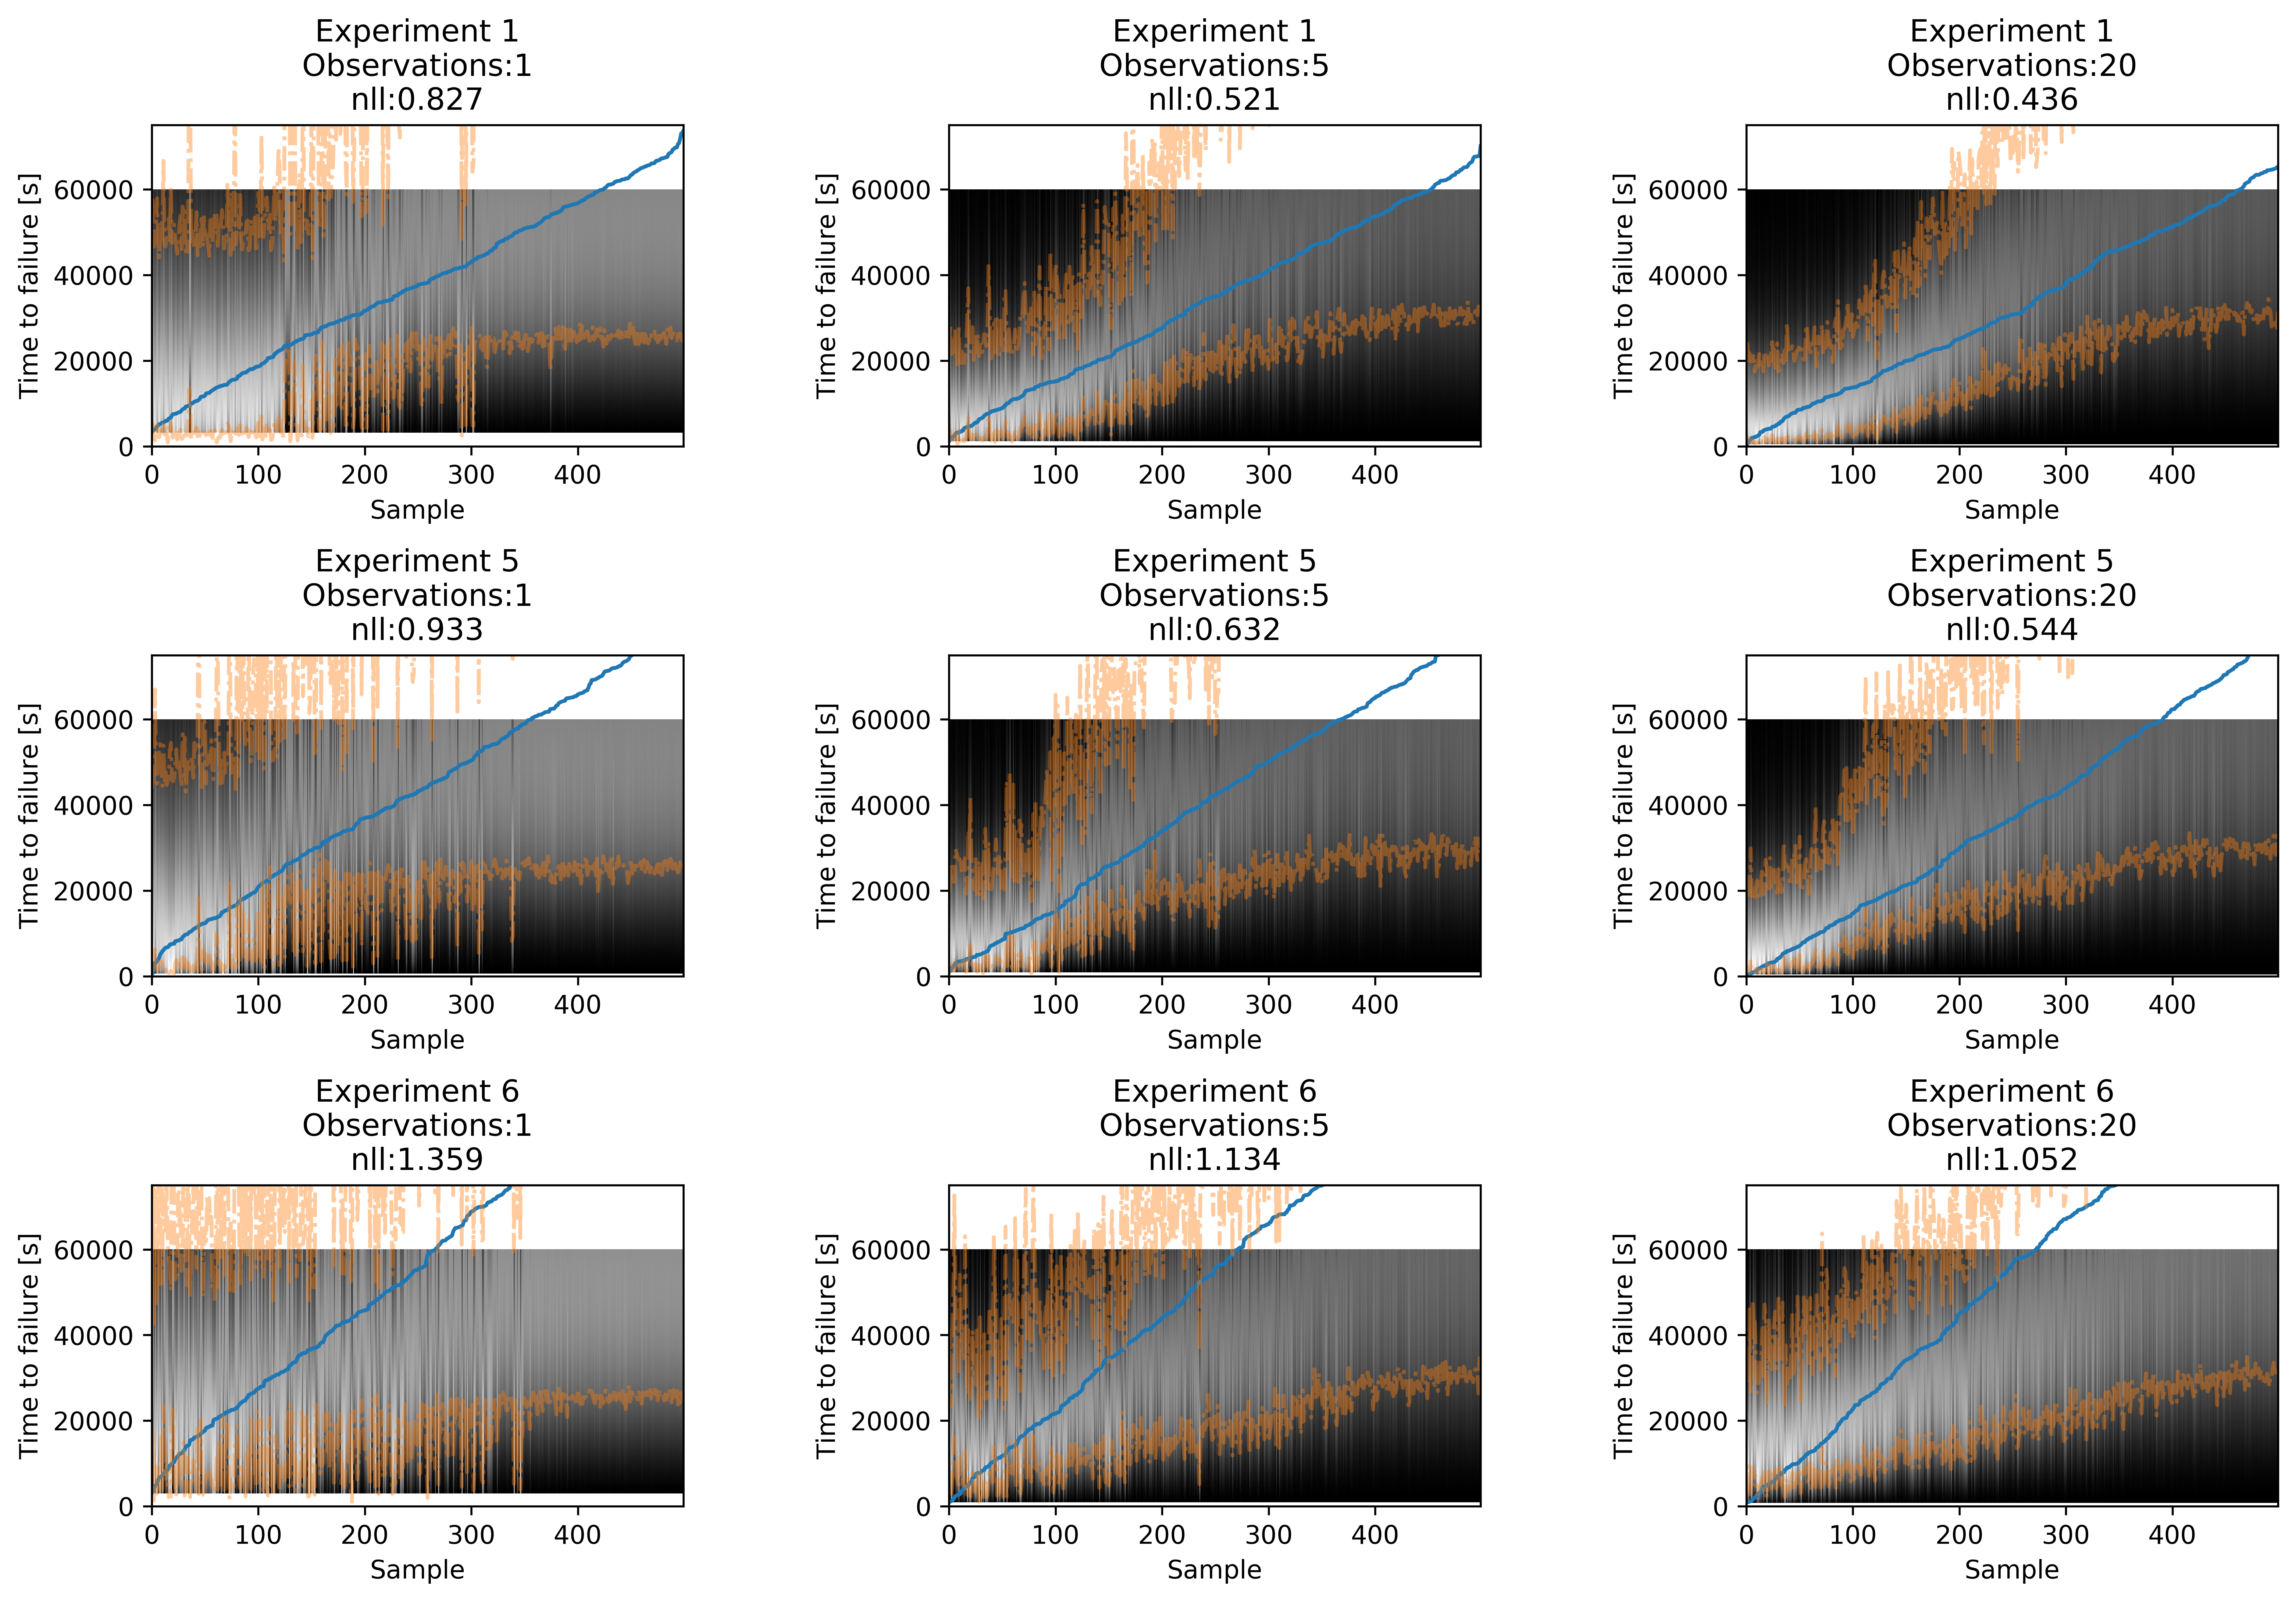

<Figure size 432x288 with 0 Axes>

In [52]:

def plot_experiments(experiments_to_plot):
    #training = inds_exp_source
    nsampled = 500

    pplot.figure(figsize = (15,10), dpi = 600)
    nnodes_list = [1,5,20]#,3,5]
    nseq_len = [200,200,200]
    minspacing= [10,10,10]
    gnsteps  = [ 5,5,5]
    
    normalization_factor_time = femto_dataset.normalization_factor_time
    kk = 0;
    for ee in experiments_to_plot:
        for nnodes, gnsteps_,nseq_,minspacing_ in zip(nnodes_list, gnsteps, nseq_len, minspacing):
            #ee = training[0]
            graphs, y_times = get_graph_data(ee, X_ = femto_dataset.X, eid_oh_ = femto_dataset.eid_oh,
                                             yrem_norm_ = femto_dataset.yrem_norm, n_sampled_graphs = nsampled, 
                                             nnodes=nnodes, fixed_spacing_indices=False, min_spacing=minspacing_,
                                             nseq_range=nseq_)
            probs = gn_tot.eval_graphnets(graphs,gnsteps_)
            #eval_graphnets()
            ids_sorted = np.argsort(y_times)
            time_grid = np.linspace(np.min(y_times),np.max(y_times), 150);
            time_grid = np.linspace(np.min(y_times), 60000./normalization_factor_time, 150)
            #time_grid = np.linspace(np.min(y_times),3.5, 150);

            e_y = probs.mean()
            p_y = probs.prob(time_grid).numpy().T

            y_times_sorted = y_times[ids_sorted];
            pplot.subplot( len(experiments_to_plot),len(nnodes_list), kk+1)
            pplot.pcolor([r for r in range(p_y.shape[1])], time_grid*normalization_factor_time, p_y[:,ids_sorted]**0.5, cmap = "gray")
            pplot.plot(y_times_sorted  *normalization_factor_time)
            q90 = np.quantile(probs.sample(1000).numpy(),[0.05,0.95],0)[:,:,0].T[ids_sorted]

            #pplot.plot(e_y.numpy()[ids_sorted]*normalization_factor_time,'C1',label = "$E[t_f]$",alpha = 0.5)<3
            pplot.plot(q90*femto_dataset.normalization_factor_time,'C1-.', alpha = 0.4)
            pplot.ylim(0,75000)
            pplot.xlabel("Sample")
            pplot.ylabel("Time to failure [s]")

            nll = -np.mean(probs.log_prob(y_times[np.newaxis].T))

            title = "Experiment %i\n Observations:%i \nnll:%2.3f"%(ee,nnodes,nll)
            pplot.title(title)
            kk+=1
            #p_y.shape
            #pplot.show()
    pplot.subplots_adjust(hspace = 0.65, wspace = 0.5)
    pplot.show()
    
#unseen =  inds_exp_source[3:6]#[4:7]#inds_exp_source[0:3] #inds_exp_target[0:3]
unseen = targets[0:3]#[0:1]#inds_exp_source[0:3] #inds_exp_target[0:3]
print("target")
plot_experiments(inds_exp_target)
pplot.savefig("graphnet_result_testset.png")
print("source:")
plot_experiments(inds_exp_source[0:3])
pplot.savefig("graphnet_result_trainset.png")

In [275]:
print("training set:")
for k,m in [(i,exp_to_cond_dict[i]) for i in inds_exp_source]:
    print("%02i %i %s %i"%(k,m, all_files[k][5:8],counts_dict[k]))
    
print("\ntesting set:")
for k,m in [(i,exp_to_cond_dict[i]) for i in inds_exp_target]:
    print("%02i %i %s %i"%(k,m, all_files[k][5:8],counts_dict[k]))
    
#plot_experiments([10])


training set:
01 0 1_7 1502
05 0 1_3 1802
06 0 1_5 2302
07 1 2_3 1202
08 0 1_4 1139
09 1 2_5 2002
13 1 2_1 911
15 0 1_1 2803

testing set:
16 0 1_6 2302
02 2 3_2 1637


In [58]:
n = Node()
Graph(n,e)

TypeError: __init__() missing 1 required positional argument: 'node_attr_tensor'

In [59]:
#plot_experiments(targets[0:2])
plot_experiments([5,2,16])


ValueError: num must be 1 <= num <= 0, not 1

<Figure size 9000x6000 with 0 Axes>

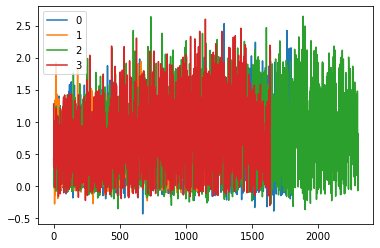

In [225]:
for m in range(len(inds_exp_target)):
    x_ = X[np.argmax(eid_oh,axis=-1) == inds_exp_target[m]]
    v = graph_indep.node_function.predict([np.zeros([x_.shape[0],1]),x_], batch_size = 100)
    pplot.plot(v[:,3], label = m)
    
pplot.legend()

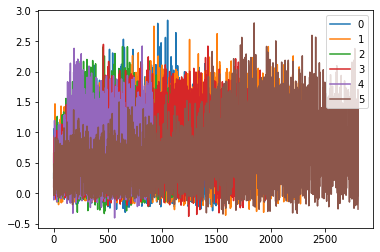

In [226]:
for m in range(len(inds_exp_source)):
    x_ = X[np.argmax(eid_oh,axis=-1) == inds_exp_source[m]]
    v = graph_indep.node_function.predict([np.zeros([x_.shape[0],1]),x_], batch_size = 100)
    pplot.plot(v[:,3], label = m)
pplot.legend()

In [48]:
plot_experiments(inds_exp_target)
#plot_experiments(inds_exp_target[2:])


NameError: name 'plot_experiments' is not defined

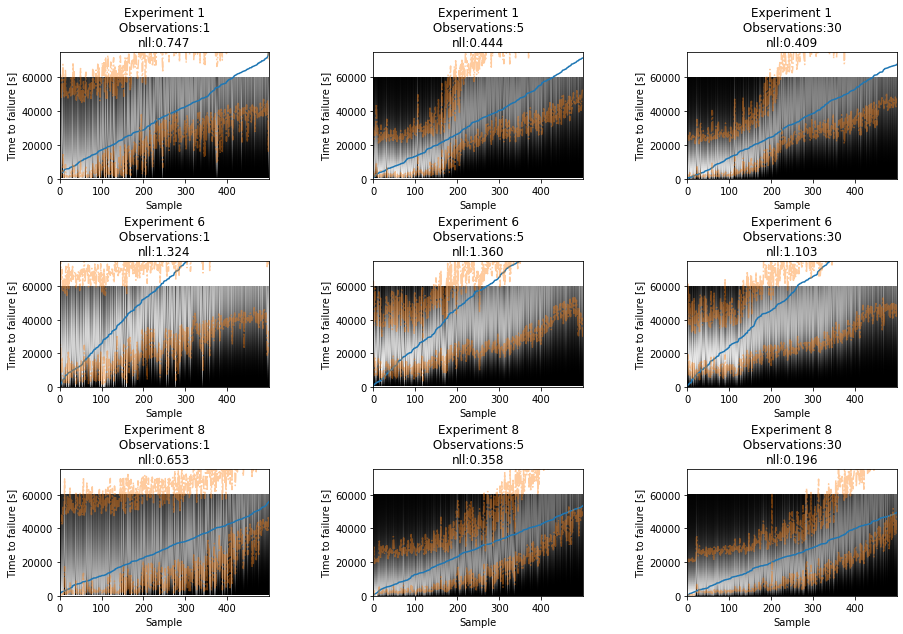

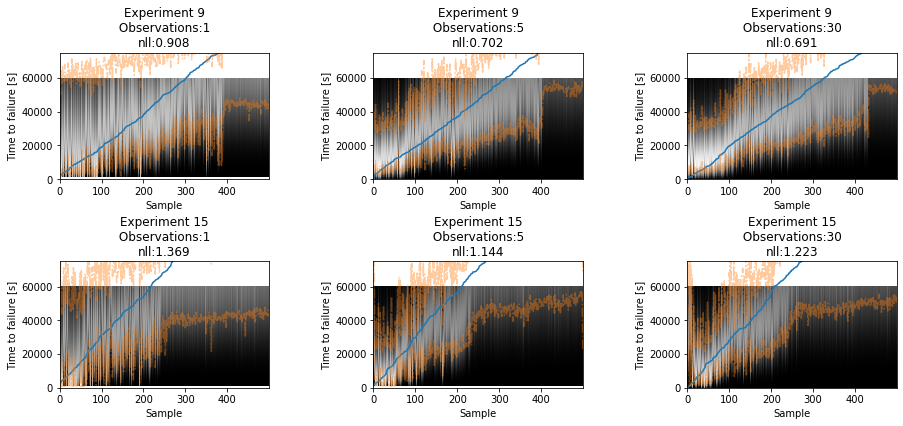

In [168]:

plot_experiments(inds_exp_source[0:3])
plot_experiments(inds_exp_source[3:6])

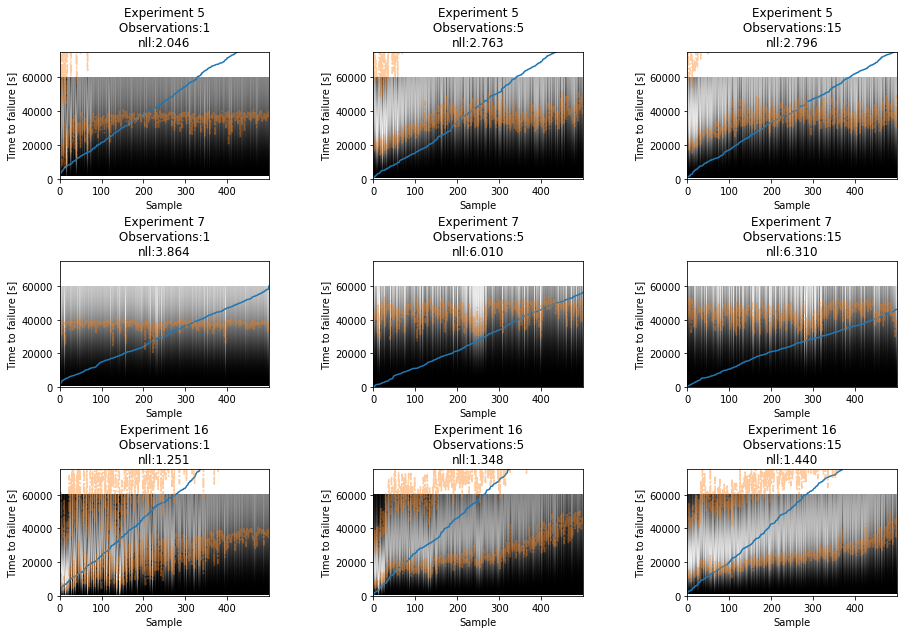

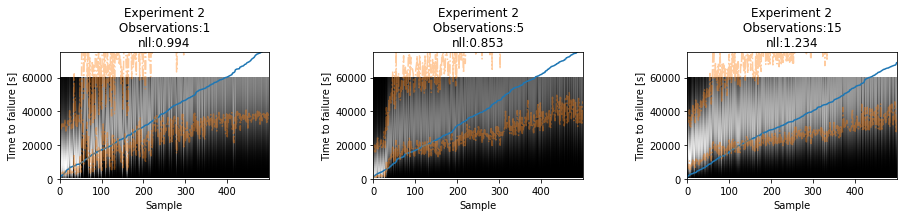

In [227]:

plot_experiments(inds_exp_target[0:3])
plot_experiments(inds_exp_target[3:])


In [119]:

inds_exp_target

[5, 7, 16, 2]

In [715]:

inds_exp_target

[5, 7, 16, 2]

In [717]:
gn